In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from scipy.special import erfc
import seaborn as sns

In [50]:
seed = 42
np.random.seed(seed)

In [51]:
# Definition of several utility functions.
def modulate(bits, modtype):
    if(modtype==2):
        symbols_bpsk = [-1.0 + 1j*0.0, 1.0 + 1j*0.0]
        ip = symbols_bpsk[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(1.0))*ip
    elif(modtype==4):
        symbols_qpsk = [-1.0 - 1j*1.0, -1.0 + 1j*1.0, 1.0 - 1j*1.0, 1.0 + 1j*1.0]
        ip = symbols_qpsk[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(2.0))*ip
    elif(modtype==16):
        symbols_16qam = [-3.0 - 1j*3.0, -3.0 - 1j*1.0, -3.0 + 1j*3.0, -3.0 + 1j*1.0, 
                         -1.0 - 1j*3.0, -1.0 - 1j*1.0, -1.0 + 1j*3.0, -1.0 + 1j*1.0, 
                         +3.0 - 1j*3.0, +3.0 - 1j*1.0, +3.0 + 1j*3.0, +3.0 + 1j*1.0,
                         +1.0 - 1j*3.0, +1.0 - 1j*1.0, +1.0 + 1j*3.0, +1.0 + 1j*1.0
                        ]
        ip = symbols_16qam[bits]
        # Normalization of energy to 1.
        symbol = (1.0/np.sqrt(10.0))*ip
    else:
        print('Error: Modulation not implemented.')
        
    return symbol

In [52]:
# Number of symbols to be transmitted.
N = 1000

# Create Es/N0 vector.
EsN0dB = 26
EsN0Lin = 10.0**(-(EsN0dB/10.0))

# Number of classes.
C = 3

# Generate random modulations.
mod = np.random.randint(0, C, (N,))

y = np.zeros((N, 1), dtype=complex)
for i in range(0, N):
    
    if(mod[i] == 0):
        # Generate BPSK symbols.
        bit_bpsk = np.random.randint(0, 2)
        # Modulate the binary stream into BPSK symbols.
        symbol = modulate(bit_bpsk, 2)
    elif(mod[i] == 1):
        # Generate QPSK symbols.
        bit_qpsk = np.random.randint(0, 4)
        # Modulate the binary stream into QPSK symbols.
        symbol = modulate(bit_qpsk, 4)
    else:
        # Generate 16QAM symbols.
        bit_16qam = np.random.randint(0, 16)
        # Modulate the binary stream into 16QAM symbols.
        symbol = modulate(bit_16qam, 16)        
        
    # Pass QPSK symbols through AWGN channel.
    noise = np.sqrt(EsN0Lin/2.0)*(np.random.randn() + 1j*np.random.randn())    
    y[i] = symbol + noise

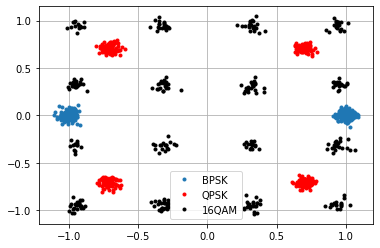

In [53]:
if(C >= 1):
    idx0 = np.argwhere(mod == 0)
    plt.plot(np.real(y[idx0.ravel()]), np.imag(y[idx0.ravel()]), '.', label='BPSK')
if(C >= 2):
    idx1 = np.argwhere(mod == 1)
    plt.plot(np.real(y[idx1.ravel()]), np.imag(y[idx1.ravel()]), 'r.', label='QPSK')
if(C >= 3):
    idx2 = np.argwhere(mod == 2)
    plt.plot(np.real(y[idx2.ravel()]), np.imag(y[idx2.ravel()]), 'k.', label='16QAM')

plt.grid()
plt.legend()
plt.show()

In [54]:
X = np.c_[np.real(y), np.imag(y)]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, mod, test_size=0.3, random_state=seed)

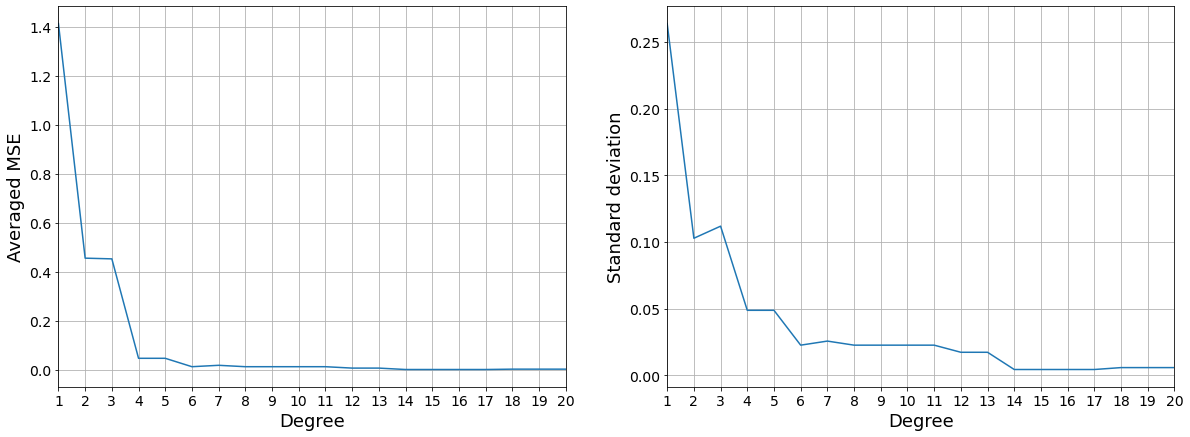

In [55]:
# Digite aqui o código do exercício.

include_bias = True

# Maximum degree to be tested.
maxDegree = 21

# Number of folds.
k = 10
# Instantiate the k-Fold object.
kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

# Iterate over the possible polynomial orders.
kfold_mean_vec = []
kfold_std_vec = []
for order in range(1,maxDegree):

    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=order, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a binary classifier.
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=seed)

    # Create a pipeline of actions.
    model = Pipeline([
        ('poly', poly), 
        ('scaler', scaler),
        ('clf', clf)
    ])
    
    # Cross-validation with k-Fold.
    neg_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)

    # Storing the scores.
    scores = -neg_scores
    kfold_mean_vec.append(scores.mean())
    kfold_std_vec.append(scores.std())

# Plot the results.
plt.figure(figsize=(20, 7))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1,maxDegree), kfold_mean_vec)
plt.ylabel('Averaged MSE', fontsize=18)
plt.xlabel('Degree', fontsize=18)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1,maxDegree-1)
plt.xticks(range(1,maxDegree))

ax = plt.subplot(1, 2, 2)
plt.plot(range(1,maxDegree), kfold_std_vec)
plt.ylabel('Standard deviation', fontsize=18)
plt.xlabel('Degree', fontsize=18)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1,maxDegree-1)
plt.xticks(range(1,maxDegree))

plt.show()

In [56]:
include_bias = True

# Instantiate a polynomial.
poly = PolynomialFeatures(degree=9, include_bias=include_bias)
# Instantiate a scaler.
scaler = StandardScaler()
# Instantiate a binary classifier.
clf = LogisticRegression(multi_class='multinomial', random_state=seed)

# Create a pipeline of actions.
model = Pipeline([
    ('poly', poly), 
    ('scaler', scaler),
    ('clf', clf)
])

# Train the model.
model.fit(X_train, y_train)

# Prediction.
y_pred = model.predict(X_test)

# Measure the model's accuracy.
acc = accuracy_score(y_test, y_pred)
print('Accuracy of Logistic Regression model is: %1.2f %%' % (acc*100))

Accuracy of Logistic Regression model is: 100.00 %


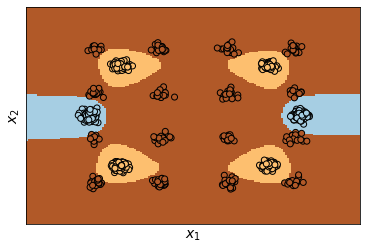

In [58]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=mod, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

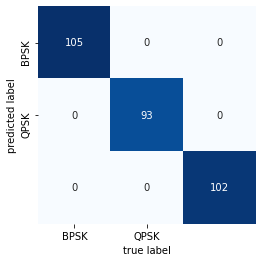

In [61]:
y_pred = model.predict(X_test)
# Plot the confusion matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['BPSK','QPSK'], yticklabels=['BPSK','QPSK'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()